In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import eda_helper_functions
from sklearn.ensemble import IsolationForest

##

In [2]:
!pip install wordcloud


## Reading data

In [3]:
file_path=r"C:\Users\91830\Desktop\Fligt Sagemaker\Data\train.csv"
train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [4]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

## 2.1 Fixed The data types

In [5]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [54]:
train = train[train['airline'].str.lower() != 'trujet']
train.sample(10)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
2005,Air India,2019-05-15,Delhi,Cochin,2025-07-20 12:55:00,2025-07-20 19:15:00,1820,2.0,No Info,13486
3093,Multiple Carriers,2019-06-03,Delhi,Cochin,2025-07-20 17:45:00,2025-07-20 01:30:00,465,1.0,No Info,7530
1708,Air India,2019-05-27,Mumbai,Hyderabad,2025-07-20 21:05:00,2025-07-20 22:25:00,80,0.0,No Info,3100
5873,Goair,2019-03-09,Delhi,Cochin,2025-07-20 06:00:00,2025-07-20 13:20:00,440,1.0,No Info,8422
732,Jet Airways,2019-06-12,Delhi,Cochin,2025-07-20 05:30:00,2025-07-20 04:25:00,1375,2.0,In-flight meal not included,10368
990,Jet Airways,2019-05-09,Kolkata,Banglore,2025-07-20 18:55:00,2025-07-20 10:05:00,910,1.0,In-flight meal not included,8586
187,Indigo,2019-03-15,Banglore,New Delhi,2025-07-20 10:10:00,2025-07-20 13:00:00,170,0.0,No Info,6144
164,Jet Airways,2019-03-09,Delhi,Cochin,2025-07-20 18:15:00,2025-07-20 04:25:00,610,1.0,In-flight meal not included,14053
2293,Air India,2019-05-01,Banglore,Delhi,2025-07-20 13:20:00,2025-07-20 16:10:00,170,0.0,No Info,6121
3419,Indigo,2019-06-01,Delhi,Cochin,2025-07-20 02:00:00,2025-07-20 07:25:00,325,1.0,No Info,5636


## 3. High Level Summary Of the data

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6694 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6694 non-null   object        
 1   date_of_journey  6694 non-null   datetime64[ns]
 2   source           6694 non-null   object        
 3   destination      6694 non-null   object        
 4   dep_time         6694 non-null   datetime64[ns]
 5   arrival_time     6694 non-null   datetime64[ns]
 6   duration         6694 non-null   int64         
 7   total_stops      6694 non-null   float64       
 8   additional_info  6694 non-null   object        
 9   price            6694 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 575.3+ KB


In [56]:
train.describe(include='number')

,duration,total_stops,price
count,6694.000000,6694.000000,6694.000000
mean,633.554676,0.801434,9031.696295
std,503.015328,0.659732,4639.484213
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,510.000000,1.000000,8283.000000
75%,923.750000,1.000000,12373.000000
max,2860.000000,3.000000,62427.000000


In [57]:
(
    train
    .assign(total_stops=train['total_stops'].astype(object))
    .describe(include='O')
)

,airline,source,destination,total_stops,additional_info
count,6694,6694,6694,6694.0,6694
unique,8,5,6,5.0,7
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,2391,2730,2730,3579.0,5248


## 4. High-level analysis of Missing Values

In [58]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


In [59]:
train['total_stops'].fillna(train['total_stops'].mean(), inplace=True)


In [60]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


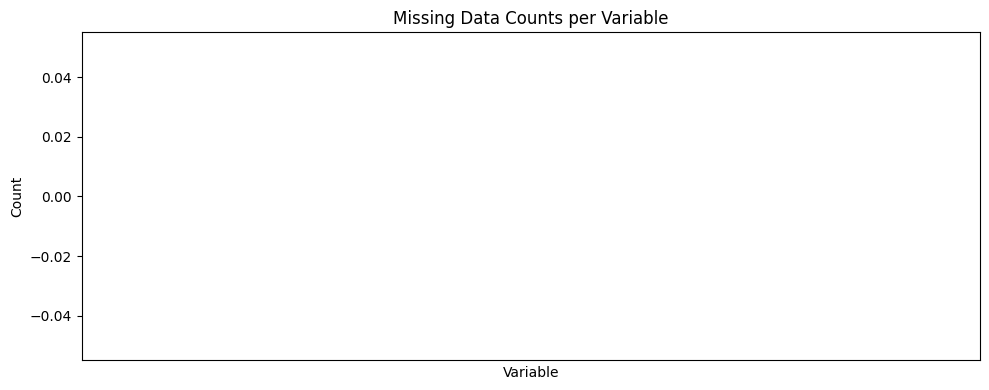

In [61]:
eda_helper_functions.plot_missing_info(train)

## 5 High level analysis of Outliers

In [62]:
# Isolation Forest can be used in case of outliers
forest=IsolationForest(n_estimators=10,random_state=42)

In [63]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                      .drop(columns='price')
                                      .select_dtypes(include='number')))
    .query('outlier == -1')
    # .duration
    # .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
5,Jet Airways,2019-04-21,Banglore,Delhi,2025-07-20 18:55:00,2025-07-20 22:00:00,185,0.0,In-flight meal not included,4544,-1
7,Spicejet,2019-06-15,Mumbai,Hyderabad,2025-07-20 05:45:00,2025-07-20 07:15:00,90,0.0,No check-in baggage included,2647,-1
9,Jet Airways,2019-05-09,Delhi,Cochin,2025-07-20 23:05:00,2025-07-20 04:25:00,1760,2.0,No Info,15129,-1
10,Jet Airways,2019-06-12,Kolkata,Banglore,2025-07-20 14:05:00,2025-07-20 10:05:00,1200,1.0,No Info,13044,-1
12,Jet Airways,2019-06-24,Delhi,Cochin,2025-07-20 21:25:00,2025-07-20 19:00:00,1295,2.0,No Info,13292,-1
...,...,...,...,...,...,...,...,...,...,...,...
6689,Indigo,2019-03-03,Mumbai,Hyderabad,2025-07-20 09:10:00,2025-07-20 10:40:00,90,0.0,No Info,5755,-1
6690,Jet Airways,2019-03-21,Delhi,Cochin,2025-07-20 10:45:00,2025-07-20 18:50:00,1925,2.0,No Info,11093,-1
6692,Jet Airways,2019-06-01,Delhi,Cochin,2025-07-20 14:00:00,2025-07-20 19:00:00,300,1.0,In-flight meal not included,10262,-1
6693,Air Asia,2019-06-24,Delhi,Cochin,2025-07-20 07:55:00,2025-07-20 13:25:00,330,1.0,No Info,6152,-1


# 6 . Pair Plots

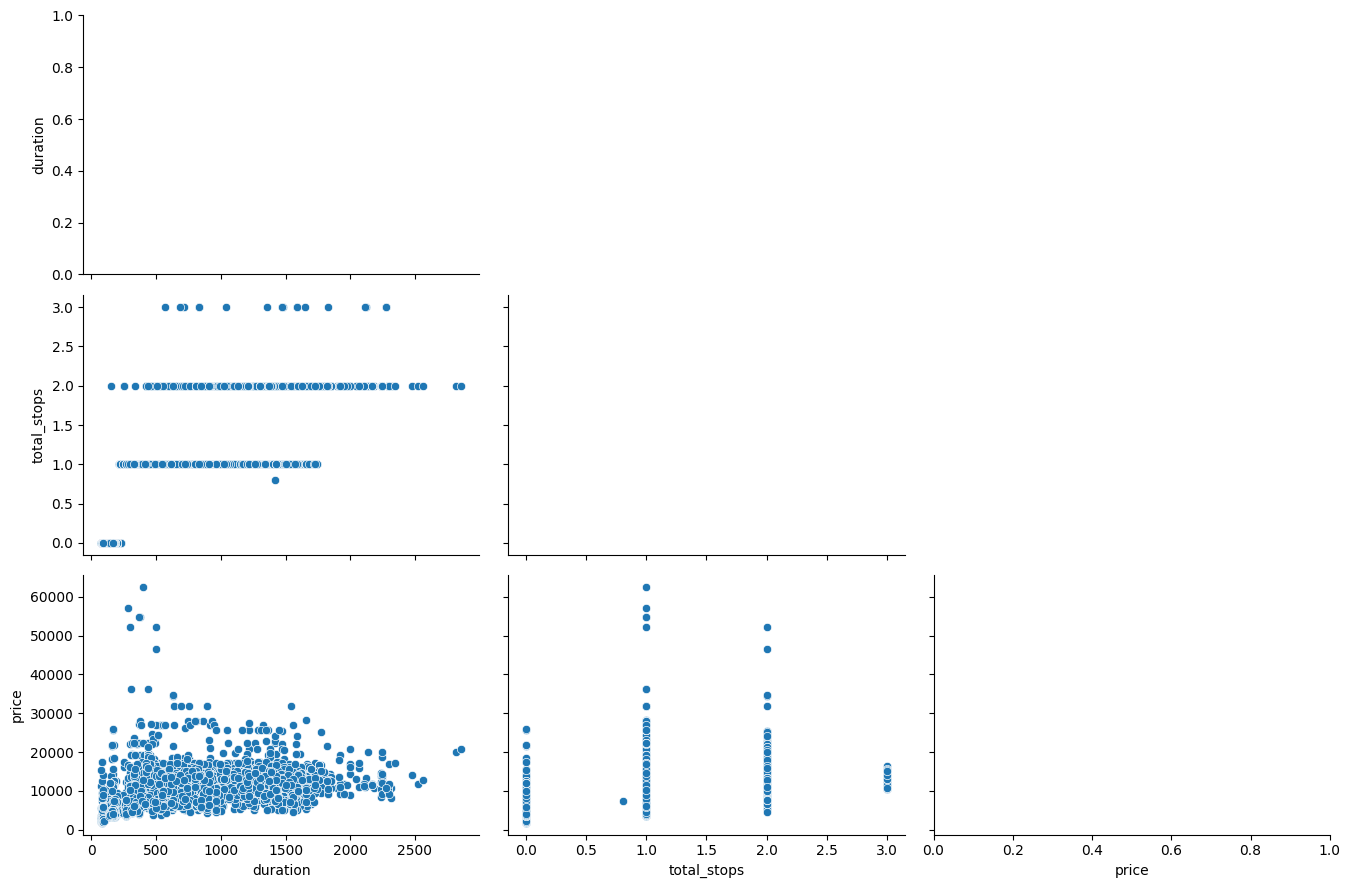

In [64]:
eda_helper_functions.pair_plots(train)


# 7 Correlation Analysis

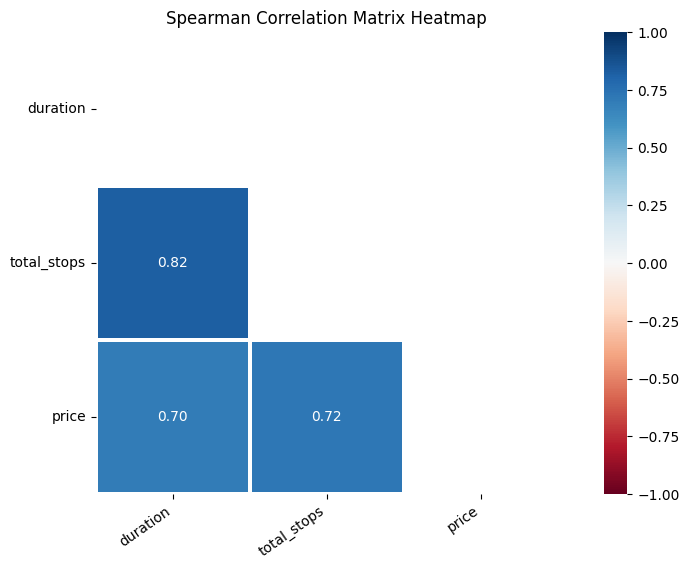

In [65]:
eda_helper_functions.correlation_heatmap(train)
# Price and duration strongly depends on each other
# total_stops and price high collinearity
# this is only for numeric data

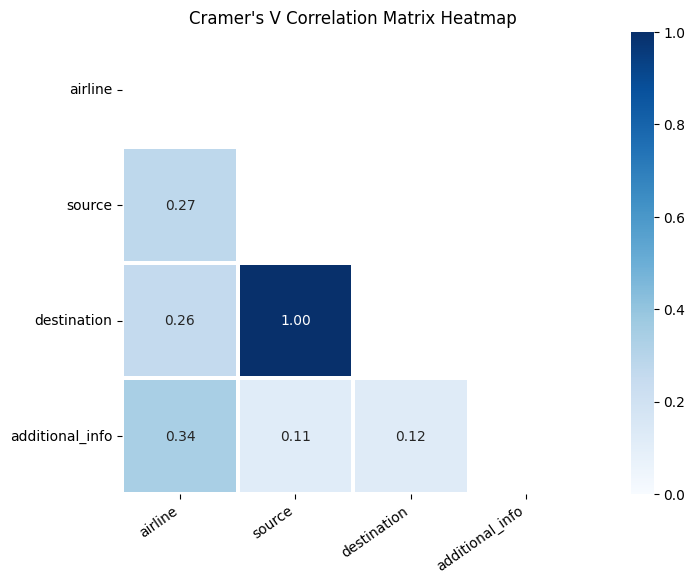

In [66]:
eda_helper_functions.cramersV_heatmap(train)

## 8. Detailed Analysis

In [67]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 Airline

In [68]:
train.airline

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6694, dtype: object

In [69]:
eda_helper_functions.cat_summary(train, "airline")


0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,8
top,Jet Airways
freq,2391


,count,percentage
category,,
Jet Airways,2391,0.357186
Indigo,1296,0.193606
Air India,1076,0.160741
Multiple Carriers,736,0.109949
Spicejet,537,0.080221
Vistara,322,0.048103
Air Asia,211,0.031521
Goair,125,0.018673


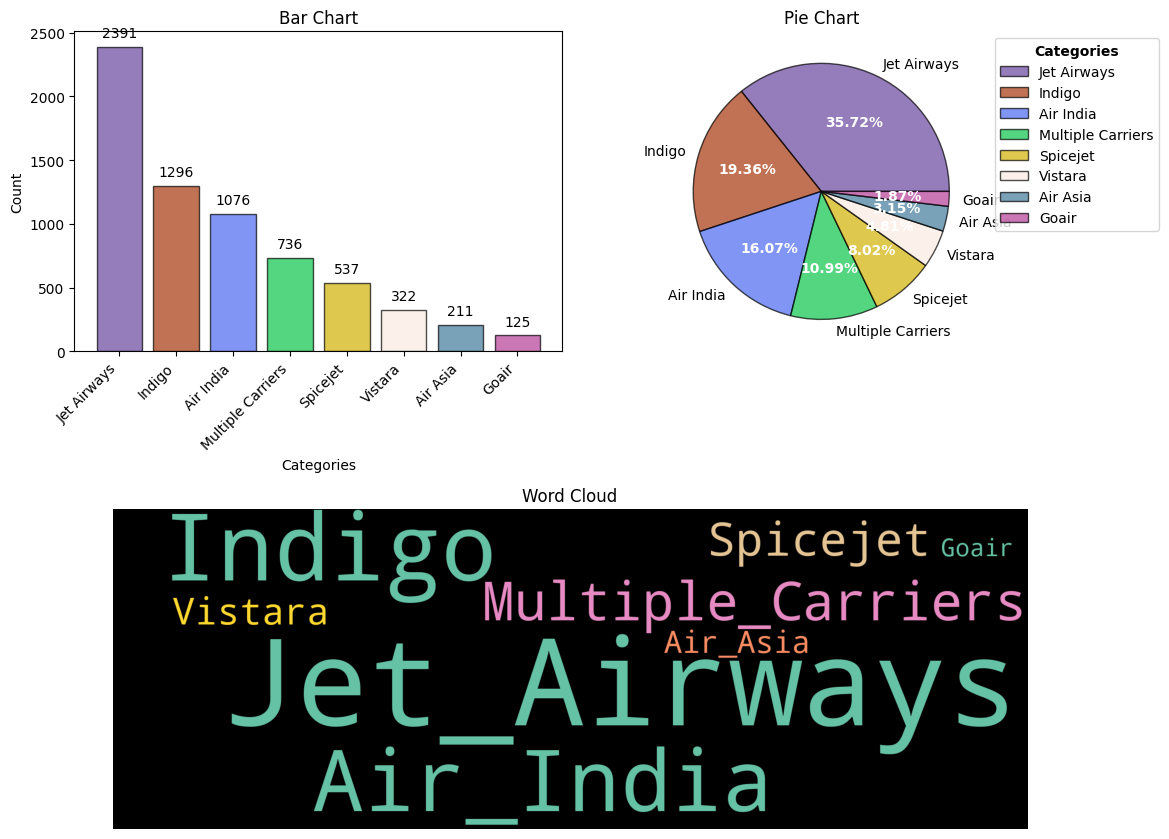

In [70]:
eda_helper_functions.cat_univar_plots(train, "airline")



# Univariate Analysis of airline

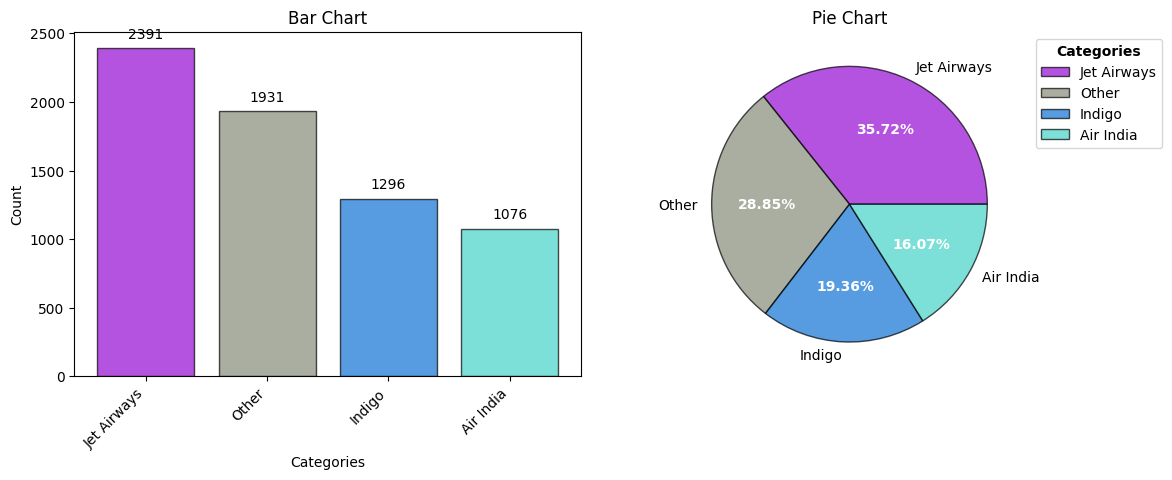

In [71]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=3)


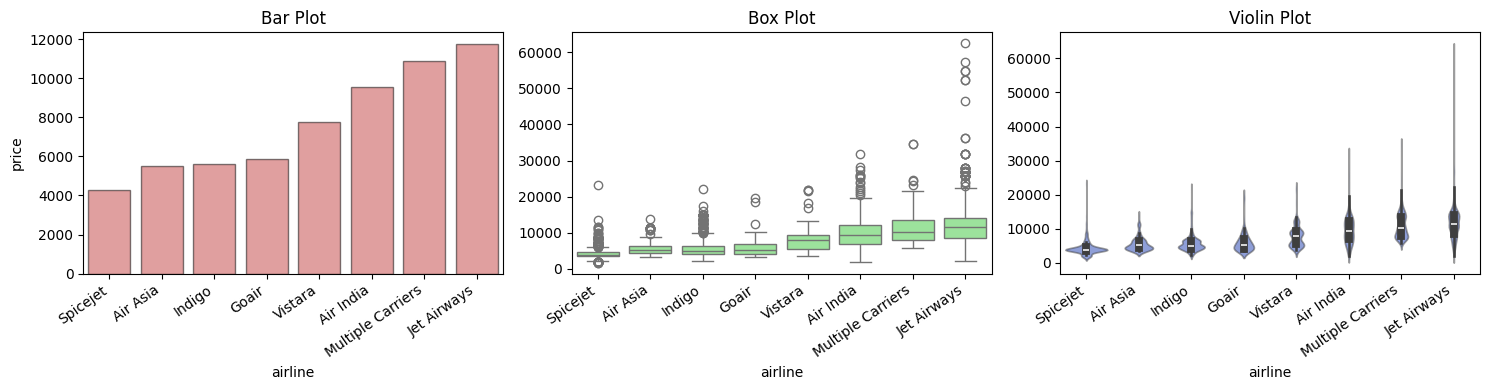

In [72]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var='price',
    cat_var='airline'
)

In [73]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 540.6438248346062
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3129.9508278874705
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


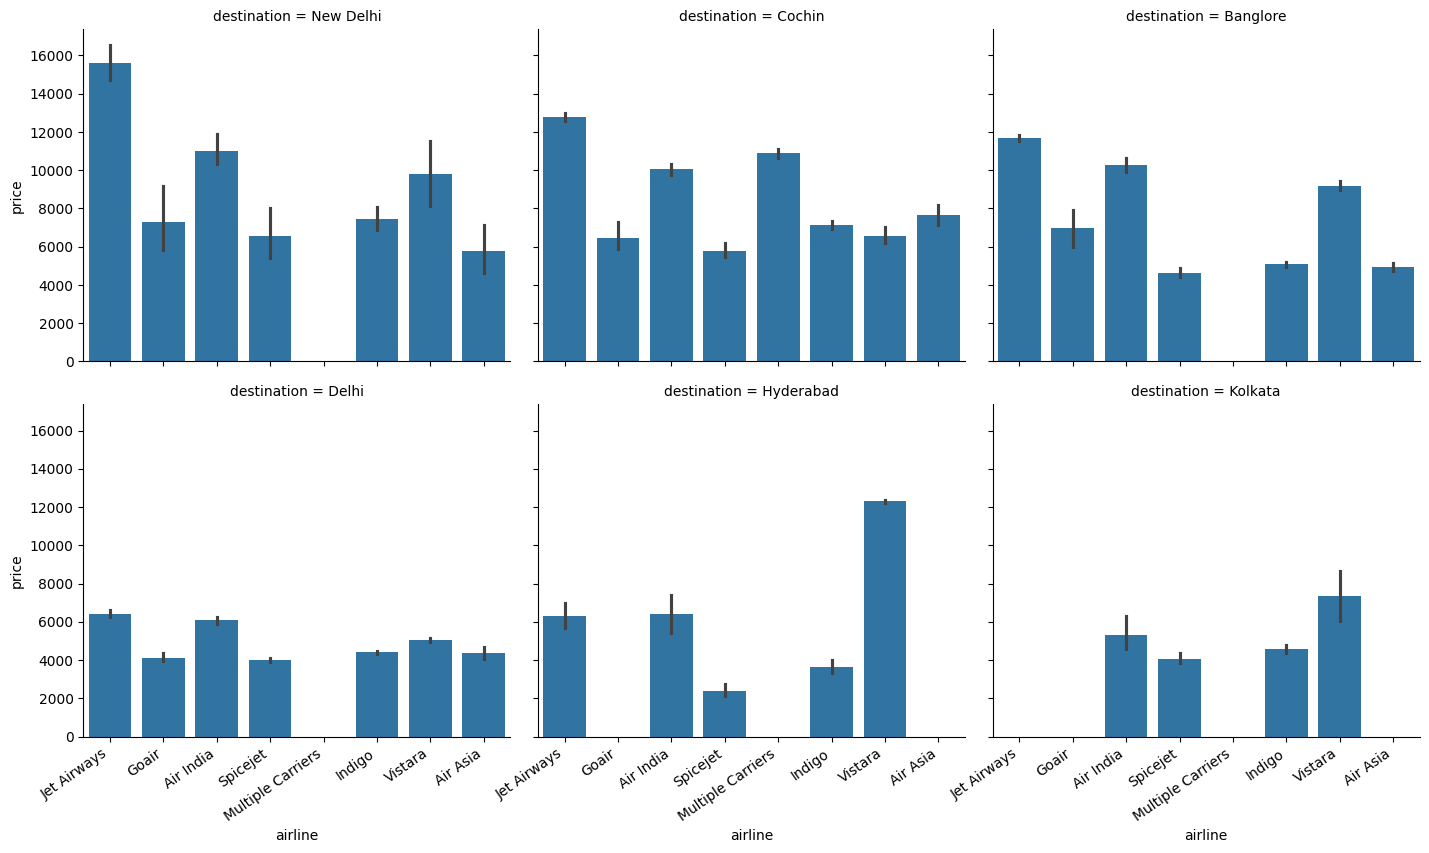

In [74]:
airline_grid = sns.FacetGrid(
	data=train,
	col="destination",
	col_wrap=3,
	height=4,
	aspect=1.2,
	sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
	eda_helper_functions.rotate_xlabels(ax)

## 8.2 date_of_journey

In [75]:
train.date_of_journey

0      2019-03-21
1      2019-03-27
2      2019-03-09
3      2019-06-12
4      2019-03-12
          ...    
6690   2019-03-21
6691   2019-05-01
6692   2019-06-01
6693   2019-06-24
6694   2019-03-01
Name: date_of_journey, Length: 6694, dtype: datetime64[ns]

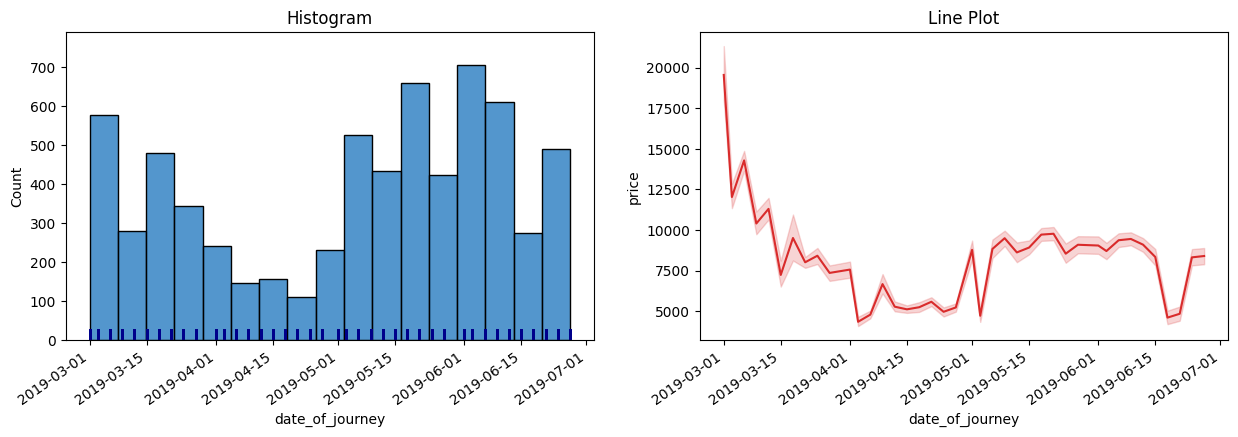

In [76]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

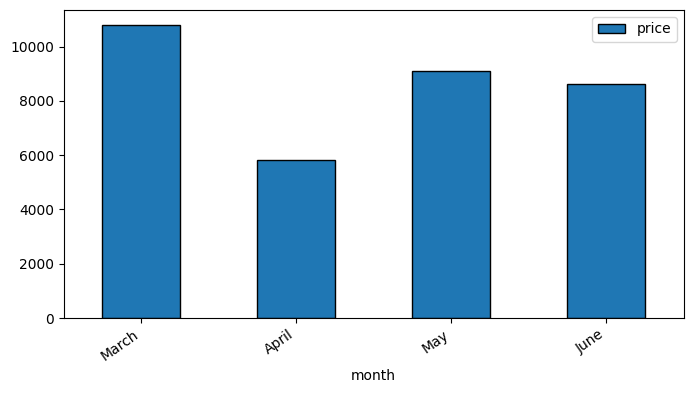

In [77]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)


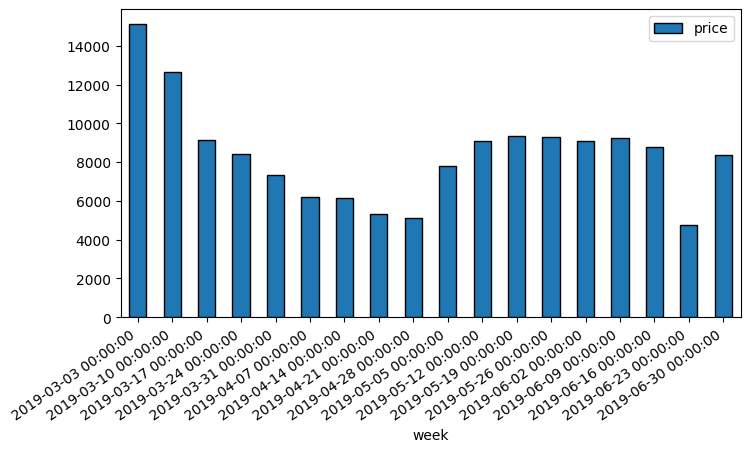

In [78]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

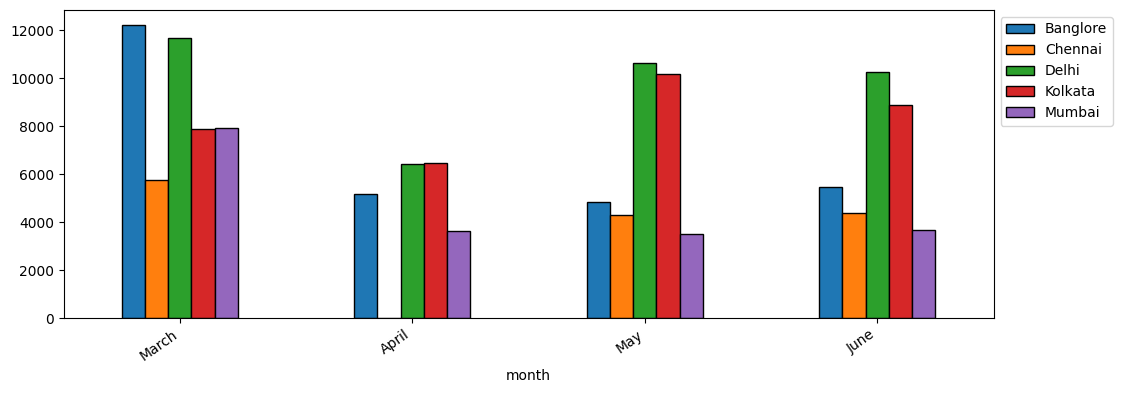

In [79]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

## 8.3 dep_time

In [80]:
train.dep_time

0      2025-07-20 08:55:00
1      2025-07-20 17:30:00
2      2025-07-20 11:40:00
3      2025-07-20 09:25:00
4      2025-07-20 22:55:00
               ...        
6690   2025-07-20 10:45:00
6691   2025-07-20 09:25:00
6692   2025-07-20 14:00:00
6693   2025-07-20 07:55:00
6694   2025-07-20 11:50:00
Name: dep_time, Length: 6694, dtype: datetime64[ns]

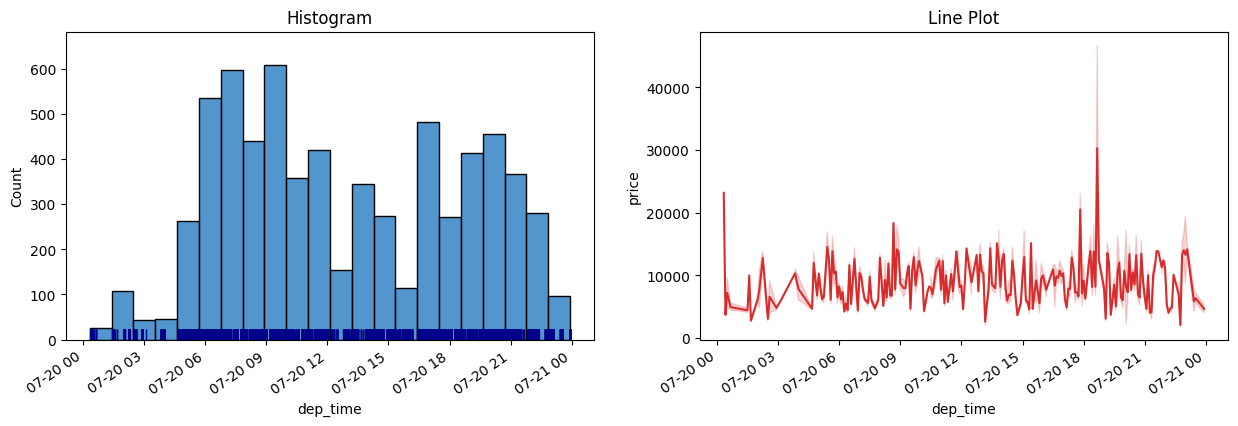

In [81]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")


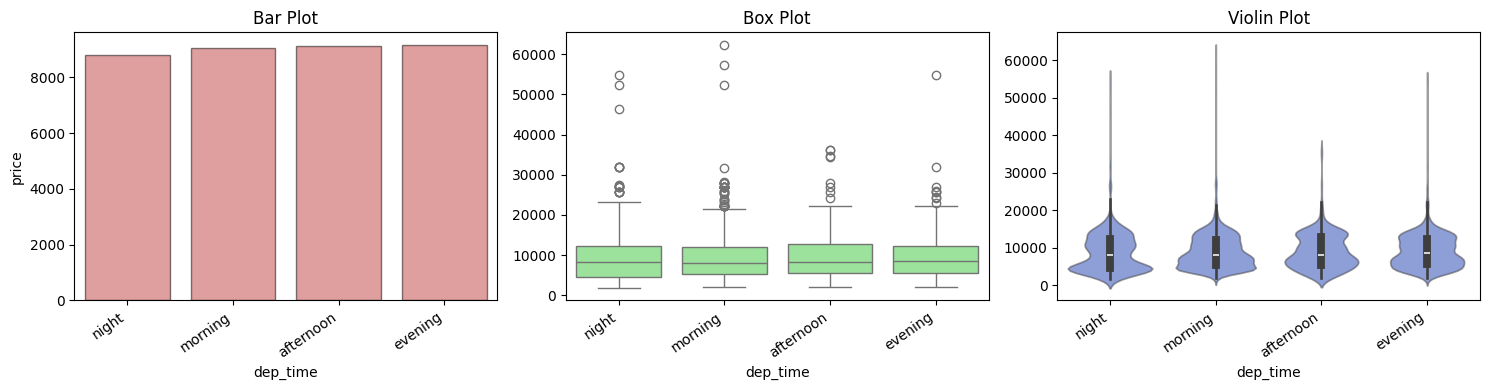

In [82]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

## 8.4 duration

In [83]:
train.duration


0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6694, dtype: int64

In [84]:
eda_helper_functions.num_summary(train, "duration")
# mad -> median absolute deviation

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6694, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,170.00
50,510.00
75,923.75
90,1440.00
95,1601.75
99,1855.00


,value
mean,633.554676
trimmed mean (5%),599.778460
trimmed mean (10%),571.123973
median,510.000000


,value
var,253024.419765
std,503.015328
IQR,753.750000
mad,340.000000
coef_variance,0.793957


,value
skewness,0.893372
kurtosis,-0.054183


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 7.561315141883336e-57
Test Statistic       : 0.8866097426136367
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 248.3093258789122
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [85]:
train.duration.quantile([0.25, 0.5, 0.75])


0.25    170.00
0.50    510.00
0.75    923.75
Name: duration, dtype: float64

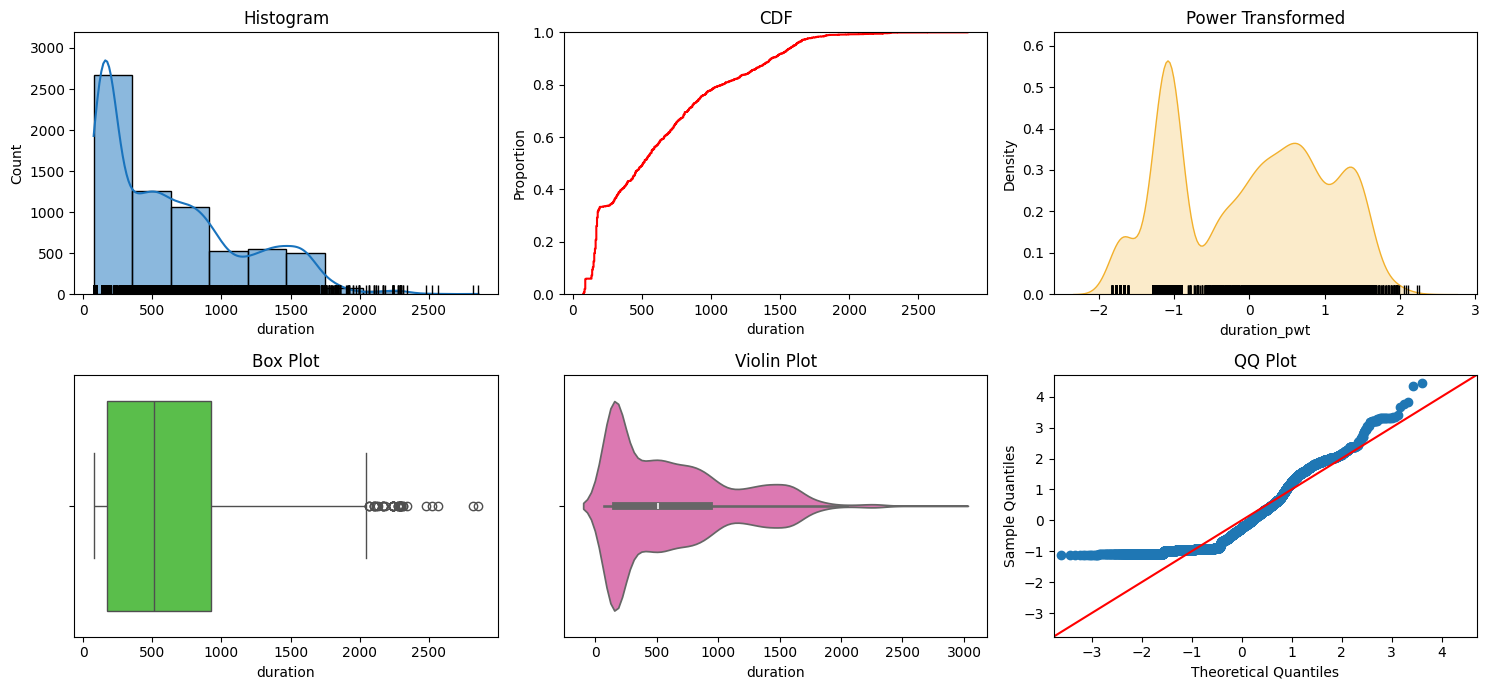

In [86]:
eda_helper_functions.num_univar_plots(train, "duration")


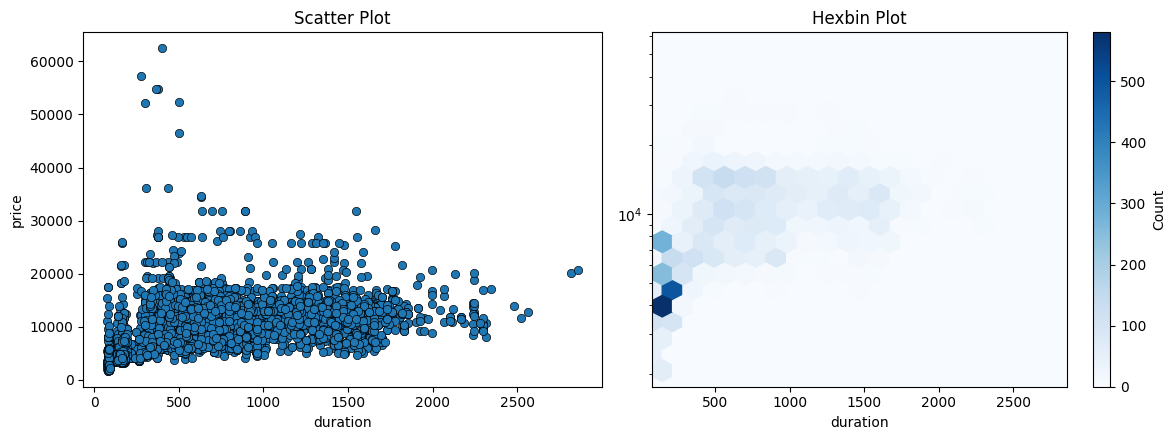

In [87]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [88]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5089462910541281
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6977990862735659
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


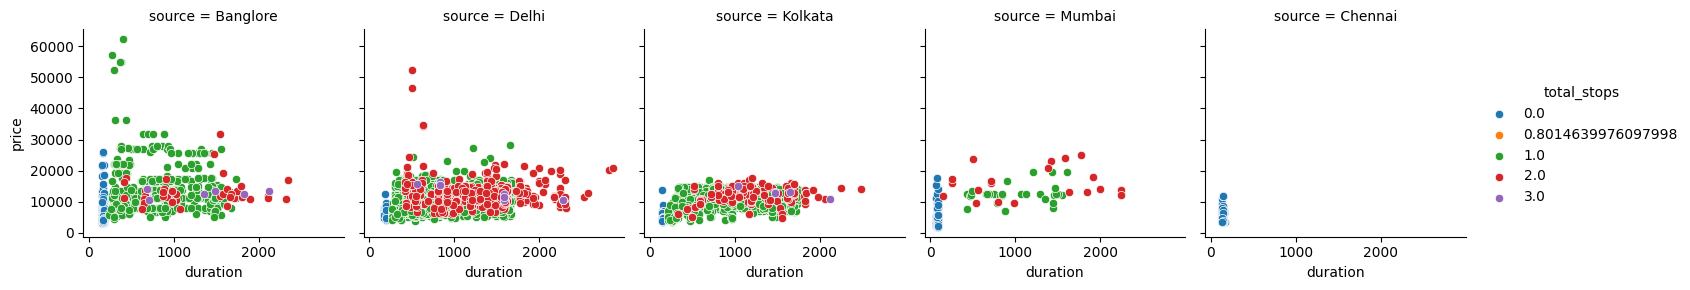

In [89]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

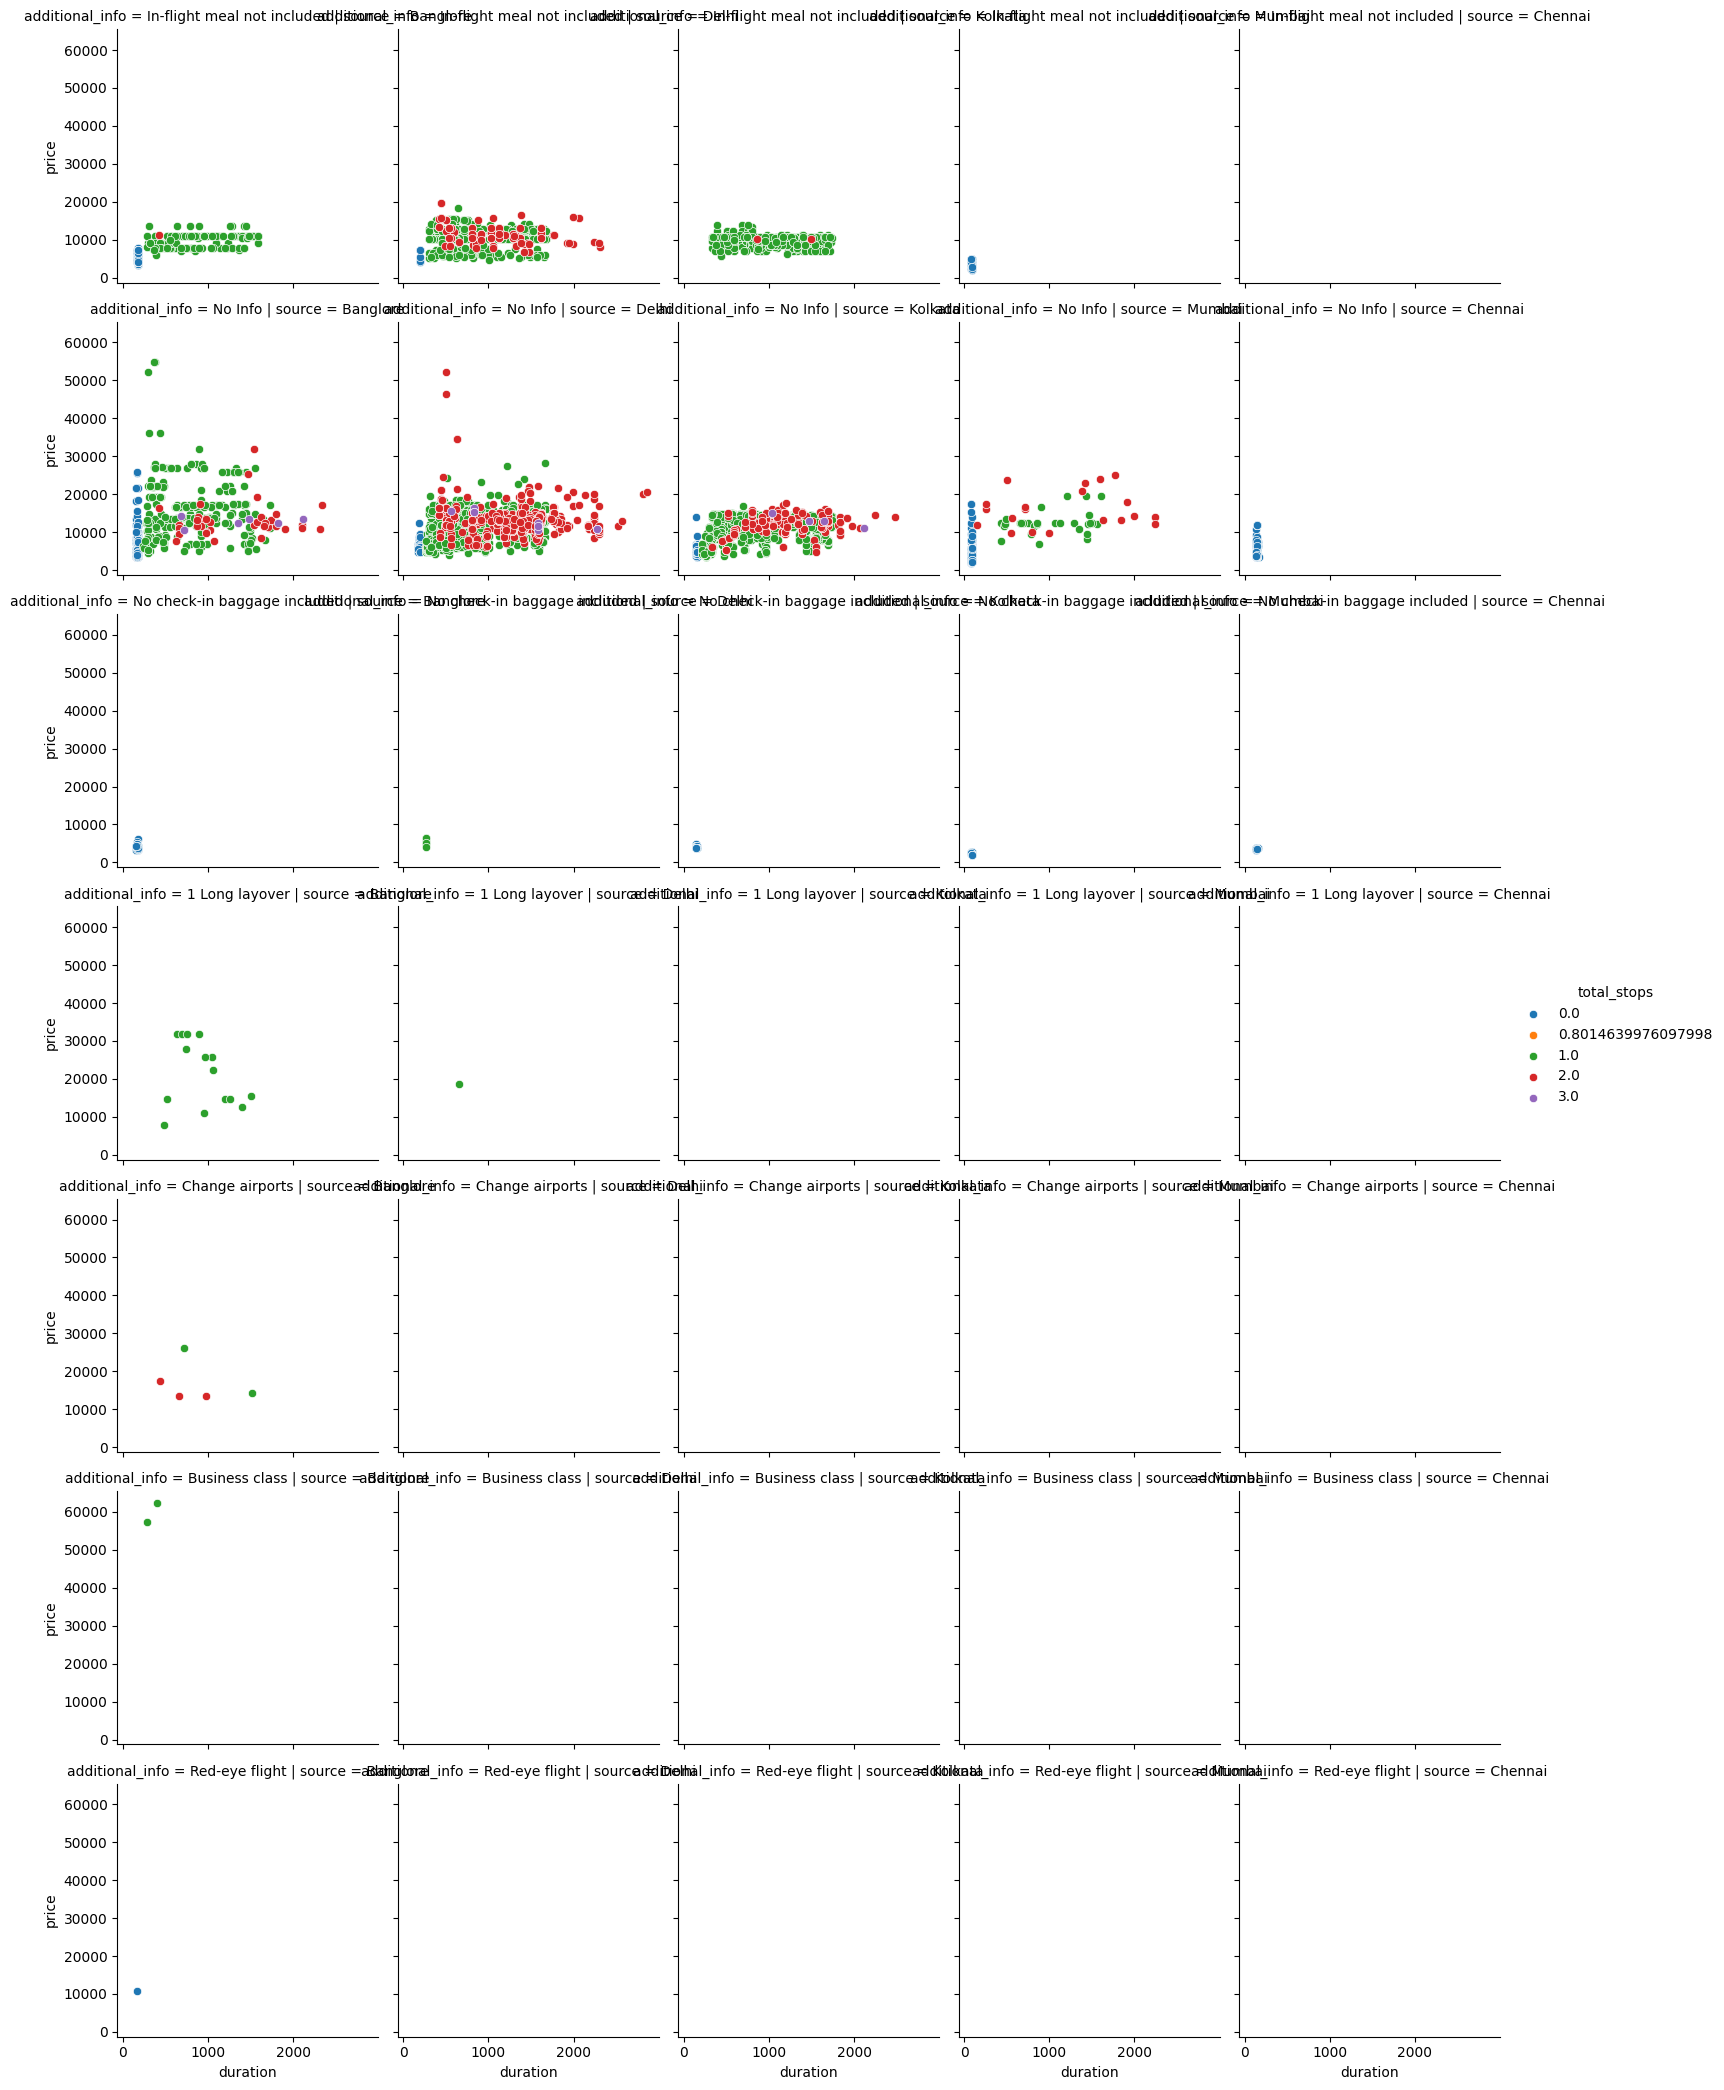

In [90]:

duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [91]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -960.625
Upper Limit : 2054.375


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3690,Air India,2019-05-01,Kolkata,Banglore,2025-07-20 05:50:00,2025-07-20 16:15:00,2065,2.0,No Info,10991
3225,Jet Airways,2019-03-06,Delhi,Cochin,2025-07-20 17:55:00,2025-07-20 04:25:00,2070,2.0,In-flight meal not included,15812
6079,Jet Airways,2019-03-06,Delhi,Cochin,2025-07-20 17:55:00,2025-07-20 04:25:00,2070,2.0,No Info,17072
1517,Air India,2019-03-03,Banglore,New Delhi,2025-07-20 11:05:00,2025-07-20 22:10:00,2105,2.0,No Info,11948
4589,Air India,2019-03-18,Banglore,New Delhi,2025-07-20 11:05:00,2025-07-20 22:10:00,2105,2.0,No Info,11161
2990,Air India,2019-03-03,Banglore,New Delhi,2025-07-20 11:05:00,2025-07-20 22:10:00,2105,2.0,No Info,11791
2916,Air India,2019-05-12,Kolkata,Banglore,2025-07-20 12:00:00,2025-07-20 23:15:00,2115,3.0,No Info,10991
2170,Air India,2019-03-12,Banglore,New Delhi,2025-07-20 06:45:00,2025-07-20 18:05:00,2120,3.0,No Info,13387
1105,Jet Airways,2019-03-06,Delhi,Cochin,2025-07-20 16:50:00,2025-07-20 04:25:00,2135,2.0,No Info,19907
3091,Air India,2019-03-03,Delhi,Cochin,2025-07-20 07:05:00,2025-07-20 19:15:00,2170,2.0,No Info,11762


# 8.5 additional_info

In [92]:
eda_helper_functions.cat_summary(train, "additional_info")

0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6690                        No Info
6691                        No Info
6692    In-flight meal not included
6693                        No Info
6694                 1 Long layover
Name: additional_info, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 7 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,7
top,No Info
freq,5248


,count,percentage
category,,
No Info,5248,0.783986
In-flight meal not included,1215,0.181506
No check-in baggage included,207,0.030923
1 Long layover,16,0.002390
Change airports,5,0.000747
Business class,2,0.000299
Red-eye flight,1,0.000149


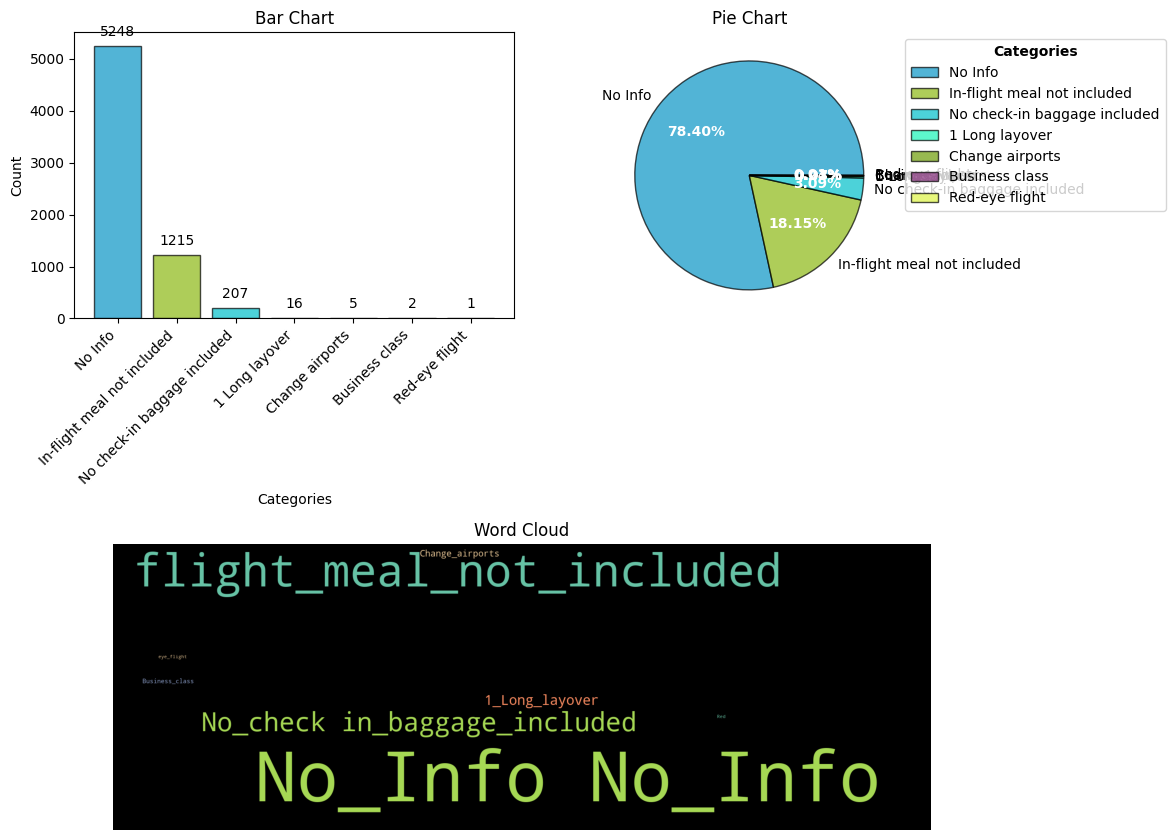

In [93]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

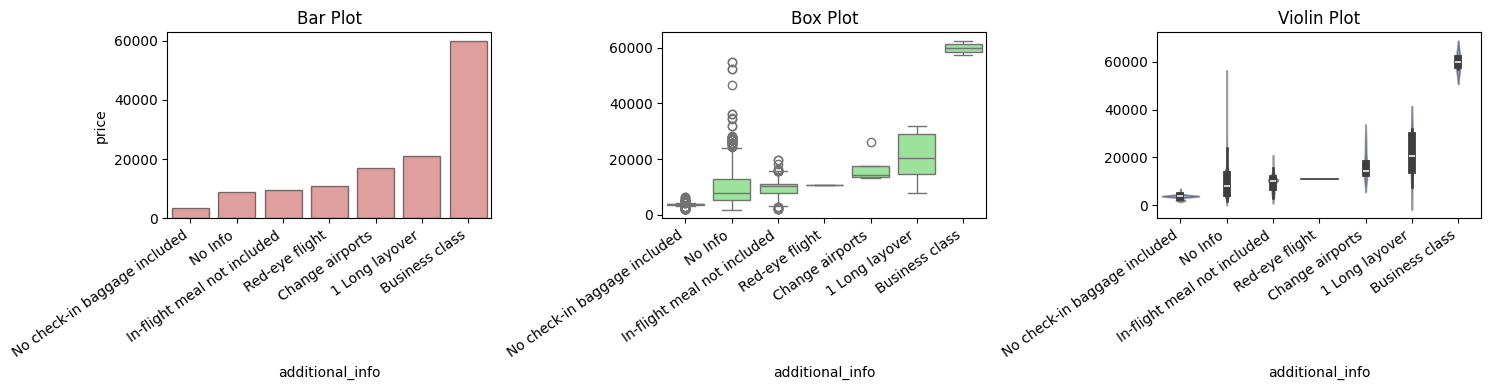

In [94]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")


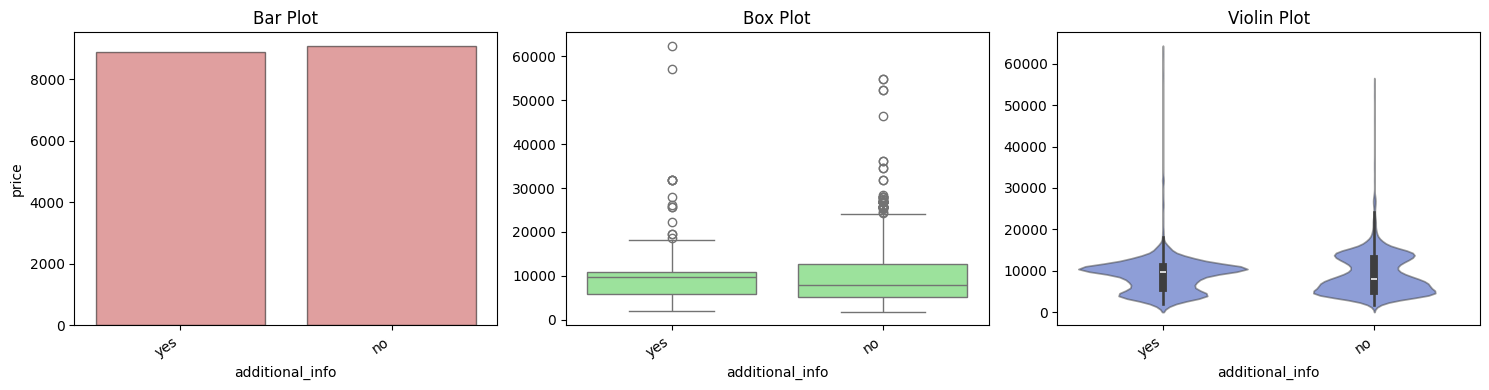

In [95]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

In [96]:
!pip install ydata-profiling



# 9. Automated EDA

In [97]:
# from ydata_profiling import ProfileReport

In [50]:
# report = ProfileReport(train)

In [51]:
# report.to_file(output_file="output.html")